# Plot the KP turbine wakes (streamwise, with updraft/downdraft)

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Important header information                                                                                                                                               
import postprolib as pp
# Load the libraries                                                                                                                                                         
import postproamrwindsample as ppsample
import numpy             as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import postproamrwindsample_xarray as ppsamplexr
import pickle
import pandas as pd

# Make all plots inline 
%matplotlib inline

In [2]:
extractvar = lambda xrds, var, i : xrds[var][i,:].data.reshape(tuple(xrds.attrs['ijk_dims'][::-1]))

def loadPickle(picklefname):
    pfile = open(picklefname, 'rb')
    db   = pickle.load(pfile)
    x    = db['x']
    y    = db['y']
    z    = db['z']
    vx   = db['vx']
    vy   = db['vy']
    vz   = db['vz']
    time = db['time']
    pfile.close()
    return x, y, z, vx, vy, vz, time

def avgfield(v, mintime, maxtime):
    avgv = None
    iavg = 0
    for itime, vfield in v.items():
        if (mintime<=itime) and (itime<=maxtime):
            iavg += 1
            if avgv is None:
                avgv = vfield
            else:
                avgv += vfield
    #print(iavg)
    return avgv/float(iavg)

def makecbarax(ax, c, fontsize, size='5%'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=fontsize)

def setfigtextsize(ax, fsize):
    fontelem = ([ax.title, ax.xaxis.label, ax.yaxis.label, 
                 ax.yaxis.get_offset_text(), ax.xaxis.get_offset_text()] + 
                ax.get_xticklabels() + ax.get_yticklabels() )
    for item in fontelem:
        item.set_fontsize(fsize)

In [3]:
def computeDSfunc(dsvec, tagname, func):
    for turb, ds in dsvec.items():
        dsvec[turb][tagname] = func(ds)

def avgDSfield(dsvec, turblist, excludekeys=['group', 'times']):
    avgds = {}
    # Get a list of all keys 
    allkeys = [k for k, g in dsvec[turblist[0]].items()]
    #print(allkeys)
    # Loop over all turbines
    for turb in turblist:
        #print(turb)
        ds = dsvec[turb]
        for key, dat in ds.items():
            if key in excludekeys: continue
            if key in avgds:
                avgds[key] = avgds[key] + dat
            else:
                avgds[key] = dat+0.0
    # normalize averages
    for key in allkeys:
        if key in excludekeys: continue
        avgds[key] = avgds[key]/float(len(turblist))
    #print(float(len(turblist)))
    return avgds

In [4]:
def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

def getTurbSubsetXY(csvfile, suffix, xlim=[-np.finfo(np.float64).max, np.finfo(np.float64).max], ylim=[-np.finfo(np.float64).max, np.finfo(np.float64).max]):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        xy = [float(x[1][' x']), float(x[1][' y'])]
        if x[1]['# name'].endswith(suffix) and ((xlim[0] <= xy[0]) and (xy[0]<=xlim[1]) and (ylim[0]<=xy[1]) and (xy[1]<=ylim[1])):
            #print(x[1])
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

getturbnames = lambda df: [x[1]['# name'] for x in df.iterrows()]

def getCartesianMesh(x,y):
    p00=np.array([x[0,0], y[0,0]])
    p10=np.array([x[1,0], y[1,0]])
    p01=np.array([x[0,1], y[0,1]])
    dx=np.linalg.norm(p00-p10)
    dy=np.linalg.norm(p00-p01)
    hhshape=x.shape
    xvec=np.arange(hhshape[1])*dx
    yvec=np.arange(hhshape[0])*dy
    xm, ym = np.meshgrid(xvec, yvec)
    return xm, ym
    #return xm.transpose(), ym.transpose()

def avgFileList(turblist, tavg1, tavg2):
    avgvx = None
    avgvy = None
    avgvz = None
    for turb in turblist:
        x, y, z, vx, vy, vz, time = loadPickle(turb)
        vx_avg = avgfield(vx, tavg1, tavg2)
        vy_avg = avgfield(vy, tavg1, tavg2)
        vz_avg = avgfield(vz, tavg1, tavg2)
        if avgvx is None:
            avgvx = vx_avg
            avgvy = vy_avg
            avgvz = vz_avg
        else:
            avgvx += vx_avg
            avgvy += vy_avg
            avgvz += vz_avg
    N = len(turblist)
    return x, y, z, avgvx/N, avgvy/N, avgvz/N

In [5]:
summitcsv    = '../../UnstableABL_farmrun_turbines.csv'
pkldir       = '../means/KPturbssw.2/'
#rundir       = '/lustre/orion/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_farmrun2_wturbs/post_processing/'
rundir       = '/lustre/orion/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_farmrun2_noturbs/post_processing/'
ncfile       = 'KPsw_64500.nc'
turbname     = '%s_sw_mean_%s.pkl'
#tavg1 = 300
#tavg2 = 999

iplane       = 0
zhh          = 90
rotorD       = 127

In [6]:
savefigs = True
figdir   = '../JRSE_figs'

In [7]:
allturblist = getturbnames(getTurbSubset(summitcsv, '-KP'))

# Do the average and stats

In [8]:
# Load the SW  pickle files
picklefile     = 'AllKP_SWplanes_noturb.pkl'
pfile          = open(picklefile, 'rb')
allds_noturb   = pickle.load(pfile)
pfile.close()

picklefile     = 'AllKP_SWplanes_wturb.pkl'
pfile          = open(picklefile, 'rb')
allds_wturb    = pickle.load(pfile)
pfile.close()


In [9]:
# compute TKE
calctke = lambda ds: 0.5*(ds['velocityx_std']**2 + ds['velocityy_std']**2 + ds['velocityz_std']**2)
computeDSfunc(allds_noturb, 'TKE', calctke)
computeDSfunc(allds_wturb, 'TKE', calctke)

In [10]:
for k, g in allds_noturb['2019-WTW-4713-KP'].items(): 
    print(k)
    #print(np.array(g).shape)
#allds_wturb['2019-WTW-4713-KP']['velocityx_avg'].shape

turbname = '2019-WTW-4655-KP'
xm, zm =  getCartesianMesh(allds_noturb[turbname]['y'][0,:,:], allds_noturb[turbname]['z'][0,:,:])
zvec=zm[:,0]
zinside = ((zhh-0.5*rotorD <= zvec) & (zvec <= zhh+0.5*rotorD))
#print(zm)

times
group
x
y
z
velocityx_avg
velocityy_avg
velocityz_avg
velocityx_std
velocityx_max
velocityx_min
velocityy_std
velocityy_max
velocityy_min
velocityz_std
velocityz_max
velocityz_min
TKE


In [11]:
# Classify turbines based on the SW pickle file
Utarget = 9
bound   = 0.1
Uhmin = Utarget*(1-bound)
Uhmax = Utarget*(1+bound)

updraftturbs   = []
downdraftturbs = []
totalw = 0
for turb in allturblist:
    ds_pre  = allds_noturb[turb]
    ds_turb = allds_wturb[turb]
    # Calculate the average W
    avgw = np.mean(ds_pre['velocityz_avg'][iplane,:,:]) 
    # Calculate the average U
    xinflow = 70
    Uvec = ds_turb['velocityx_avg'][iplane,:,xinflow]
    Vvec = ds_turb['velocityy_avg'][iplane,:,xinflow]
    Uhvec = np.sqrt(Uvec**2 + Vvec**2)
    avgU = np.mean(Uhvec[zinside])
    if (Uhmin <= avgU) and (avgU <= Uhmax):
        print('%s %f %f'%(turb, avgw, avgU))
        if avgw > 0.0:
            updraftturbs.append(turb)
        else:
            downdraftturbs.append(turb)
        totalw += avgw

print('Number of turbines in updraft: %i'%len(updraftturbs))
print('Number of turbines in downdraft: %i'%len(downdraftturbs))
print("Averaged W = %f"%(avgw/(len(updraftturbs)+len(downdraftturbs))))

2019-WTW-4713-KP -0.092251 8.645789
2019-WTW-4726-KP -0.095803 9.317388
2019-WTW-4671-KP -0.128354 8.162089
2019-WTW-4715-KP 0.448964 8.222813
2019-WTW-4691-KP 0.301331 8.485427
2019-WTW-7913-KP -0.102486 8.821547
2019-WTW-4694-KP -0.122520 9.447356
2019-WTW-4718-KP 0.066430 8.835714
2019-WTW-4690-KP -0.124008 8.763075
2019-WTW-4656-KP -0.026698 8.143659
2019-WTW-4697-KP -0.111735 8.736650
2019-WTW-4701-KP -0.141329 8.373783
2019-WTW-4723-KP 0.119974 8.709557
2019-WTW-4673-KP -0.381540 9.065556
2019-WTW-4716-KP -0.005966 8.873389
2019-WTW-4693-KP 0.181245 8.311204
2019-WTW-4725-KP -0.256489 9.484592
2019-WTW-7915-KP 0.089495 8.694744
2019-WTW-4689-KP -0.082134 8.476362
2019-WTW-4648-KP -0.120261 8.494697
2019-WTW-4721-KP -0.157111 8.273571
2019-WTW-4652-KP 0.211636 8.148572
2019-WTW-4658-KP -0.149141 8.271045
2019-WTW-4692-KP 0.293034 8.553749
2019-WTW-4702-KP -0.111244 8.925375
2019-WTW-4704-KP -0.179099 8.348049
2019-WTW-7916-KP 0.029589 8.457418
2019-WTW-4711-KP -0.050220 8.322586
2

In [12]:
# Write out the list
with open('updraftturbines.txt', 'w') as f:
    for t in updraftturbs:  f.write(f"{t}\n")

with open('downdraftturbines.txt', 'w') as f:
    for t in downdraftturbs:  f.write(f"{t}\n")    

In [13]:
# Read in the turbines with no averaged flow
with open('nodraftturbines.txt') as f:
    nodraftturbs = f.read().splitlines()

In [14]:
# Calculate TKE
avgup_noturb   = avgDSfield(allds_noturb, updraftturbs[:])
avgup_wturb    = avgDSfield(allds_wturb,  updraftturbs[:])
avgdown_wturb  = avgDSfield(allds_wturb,  downdraftturbs[:])
avgdown_noturb = avgDSfield(allds_noturb, downdraftturbs[:])

avgflat_wturb  = avgDSfield(allds_wturb,  nodraftturbs[:])
avgflat_noturb = avgDSfield(allds_noturb, nodraftturbs[:])
#print(avgdown_wturb['z'][0,:,0])

## Make some plots

In [15]:
# Get the grid
xm, zm =  getCartesianMesh(avgdown_wturb['y'][0,:,:], avgdown_wturb['z'][0,:,:])
xp, zp = (xm)-1020, (zm)  # Center the coordinates

TKElevels = np.linspace(0, 6, 61)
wlevels   = np.linspace(-1,1,41)
vlevels   = np.linspace(0,12,41)

Text(0.5, 0.95, 'TKE [$m^2/s^2$]')

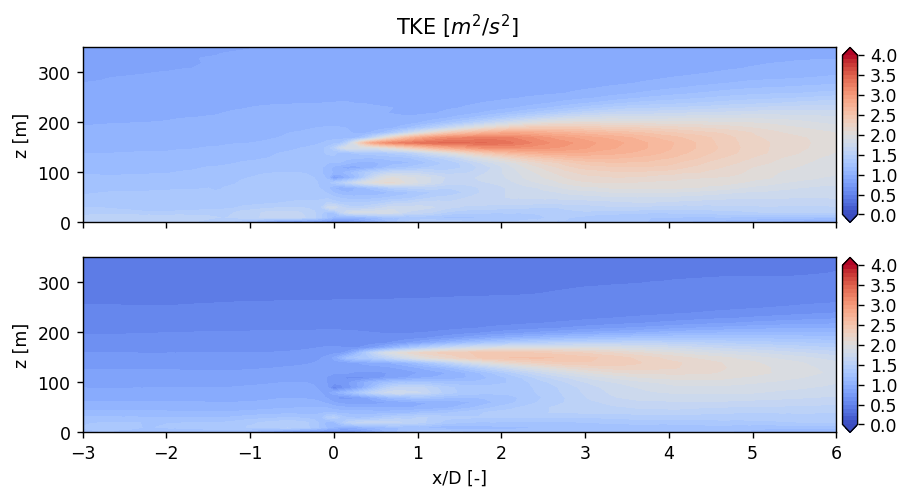

In [16]:
plotvar= 'TKE'
levels = np.linspace(0, 4, 41) 
fig, axs = plt.subplots(2, 1, figsize=(8, 4), dpi=125, sharex=True)
c0=axs[0].contourf(xp/rotorD, zp, avgup_wturb[plotvar][0,:,:],   levels=levels, cmap='coolwarm', extend='both')
c1=axs[1].contourf(xp/rotorD, zp, avgdown_wturb[plotvar][0,:,:], levels=levels, cmap='coolwarm', extend='both')

# Add colorbar
cax = make_axes_locatable(axs[0]).append_axes("right", size="2%", pad=0.05)
cbar=fig.colorbar(c0, ax=axs[0], cax=cax)
cax = make_axes_locatable(axs[1]).append_axes("right", size="2%", pad=0.05)
cbar=fig.colorbar(c1, ax=axs[1], cax=cax)

for ax in axs:
    ax.set_ylabel('z [m]')
    ax.set_xlim([-3, 6])
    ax.set_ylim([0, 350])
axs[1].set_xlabel('x/D [-]')
fig.suptitle('TKE [$m^2/s^2$]', y=0.95)

Text(0.5, 0.95, 'Vertical velocity W [m/s]')

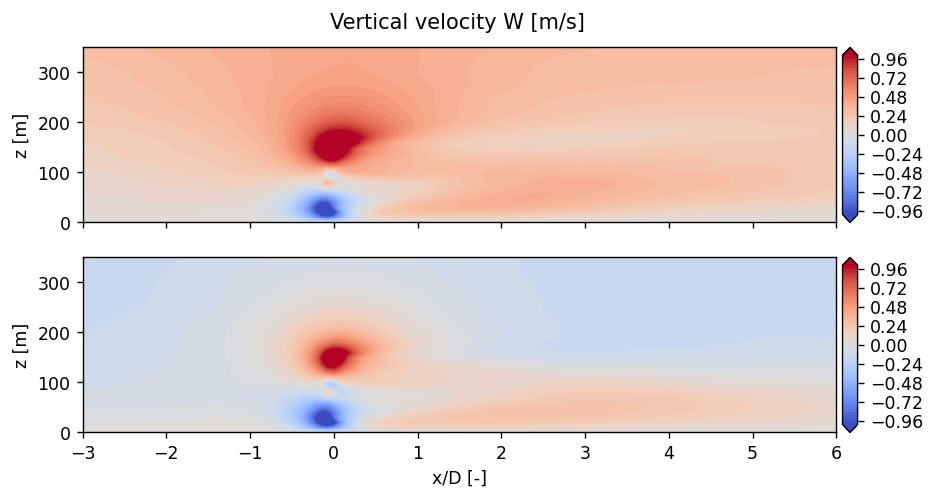

In [17]:
plotvar= 'velocityz_avg'
levels = np.linspace(-1, 1, 51) 
fig, axs = plt.subplots(2, 1, figsize=(8, 4), dpi=125, sharex=True)
c0=axs[0].contourf(xp/rotorD, zp, avgup_wturb[plotvar][0,:,:],   levels=levels, cmap='coolwarm', extend='both')
c1=axs[1].contourf(xp/rotorD, zp, avgdown_wturb[plotvar][0,:,:], levels=levels, cmap='coolwarm', extend='both')

# Add colorbar
cax = make_axes_locatable(axs[0]).append_axes("right", size="2%", pad=0.05)
cbar=fig.colorbar(c0, ax=axs[0], cax=cax)
cax = make_axes_locatable(axs[1]).append_axes("right", size="2%", pad=0.05)
cbar=fig.colorbar(c1, ax=axs[1], cax=cax)

for ax in axs:
    ax.set_ylabel('z [m]')
    ax.set_xlim([-3, 6])
    ax.set_ylim([0, 350])
axs[1].set_xlabel('x/D [-]')
fig.suptitle('Vertical velocity W [m/s]', y=0.95)

Text(0.5, 0.95, 'Horizontal velocity W [m/s]')

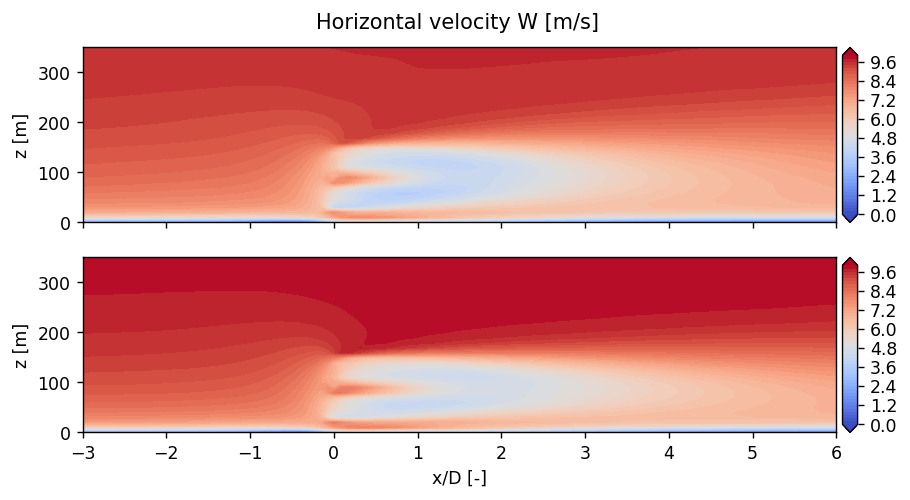

In [18]:
#plotvar= 'velocityz_avg'
levels = np.linspace(0, 10, 51) 
fig, axs = plt.subplots(2, 1, figsize=(8, 4), dpi=125, sharex=True)
Uh_up = np.sqrt(avgup_wturb['velocityx_avg'][0,:,:]**2 + avgup_wturb['velocityy_avg'][0,:,:]**2)
Uh_down = np.sqrt(avgdown_wturb['velocityx_avg'][0,:,:]**2 + avgdown_wturb['velocityy_avg'][0,:,:]**2)

c0=axs[0].contourf(xp/rotorD, zp, Uh_up[:,:],   levels=levels, cmap='coolwarm', extend='both')
c1=axs[1].contourf(xp/rotorD, zp, Uh_down[:,:], levels=levels, cmap='coolwarm', extend='both')

# Add colorbar
cax = make_axes_locatable(axs[0]).append_axes("right", size="2%", pad=0.05)
cbar=fig.colorbar(c0, ax=axs[0], cax=cax)
cax = make_axes_locatable(axs[1]).append_axes("right", size="2%", pad=0.05)
cbar=fig.colorbar(c1, ax=axs[1], cax=cax)

for ax in axs:
    ax.set_ylabel('z [m]')
    ax.set_xlim([-3, 6])
    ax.set_ylim([0, 350])
axs[1].set_xlabel('x/D [-]')
fig.suptitle('Horizontal velocity W [m/s]', y=0.95)

## Plot profiles

In [28]:
def makelegend(showprecursor=True):
    # And Legend
    legfig, legax = plt.subplots(1, 1, figsize=(4, 0.75), dpi=125, sharey=True)
    legax.axis('off')
    legfontsize=10
    legend1 = plt.legend([#Line2D([0],[0], linestyle='None', marker='+', color='k', lw=0.75), 
                          Line2D([0],[0], linestyle='-',  color='gray', lw=0.75), 
                          Line2D([0],[0], linestyle='--', color='gray', lw=0.75),
                         ], 
                         ['Wind farm run','Precursor run', ], 
                         fontsize=legfontsize, frameon=False, loc='upper center', ncol=2)
    if showprecursor:
        legax.add_artist(legend1)

    legend2 = plt.legend([
                          Line2D([0],[0], linestyle='-', color='r', lw=1), 
                          Line2D([0],[0], linestyle='-', color='b', lw=1),
                          Line2D([0],[0], linestyle='-', color='k', lw=1),
                         ], 
                         ['Updraft','Downdraft', 'Flat'], 
                         fontsize=legfontsize, frameon=False, loc='lower center', ncol=3)
    legax.add_artist(legend2)
    return

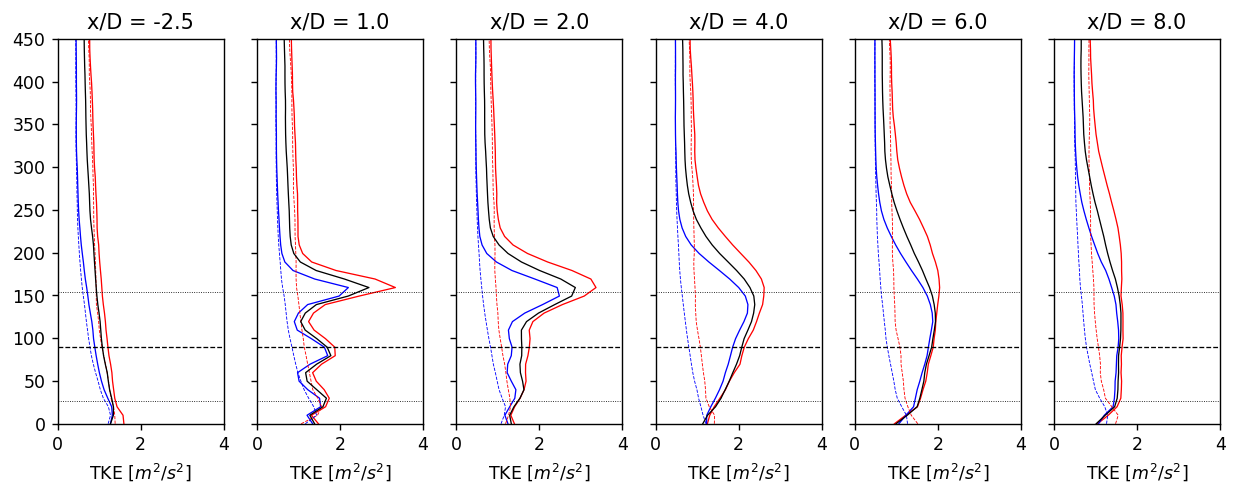

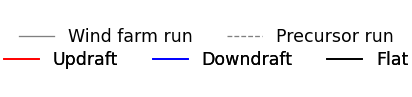

In [20]:
# TKE plots
yvec=zp[:,0]
xvec=xp[0,:]
ivec = [70, 115, 127, 153, 178, 204]

fig, axs = plt.subplots(1, len(ivec), figsize=(12, 4), dpi=125, sharey=True)
plotvar = 'TKE'
for ix, ax in enumerate(axs):
    i = ivec[ix]
    ax.plot(avgup_wturb[plotvar][0,:,i], yvec, 'r', lw=0.75, label='Updraft')
    ax.plot(avgdown_wturb[plotvar][0,:,i], yvec, 'b', lw=0.75, label='Downdraft')
    ax.plot(avgup_noturb[plotvar][0,:,i], yvec, 'r--', lw=0.5)
    ax.plot(avgdown_noturb[plotvar][0,:,i], yvec, 'b--', lw=0.5)

    ax.plot(avgflat_wturb[plotvar][0,:,i], yvec,  'k', lw=0.75, label='Flat')
    #ax.plot(avgflat_noturb[plotvar][0,:,i], yvec, 'k--', lw=0.5)

    ax.set_title('x/D = %0.1f'%(xvec[i]/rotorD))

    ax.set_xlabel('TKE [$m^2/s^2$]')
    ax.axhline(zhh, ls='--', color='k', lw=0.75)
    ax.axhline(zhh+0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.axhline(zhh-0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 450])
    
#axs[-1].legend(loc='upper left')
makelegend()

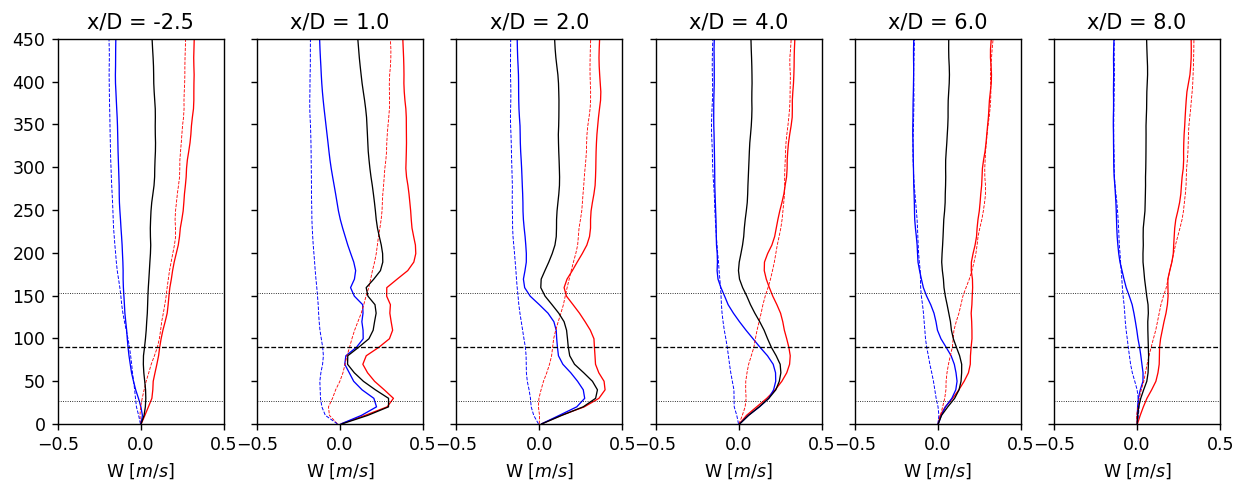

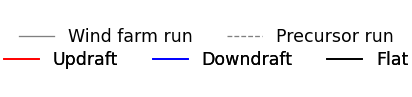

In [21]:
# W plots
yvec=zp[:,0]
xvec=xp[0,:]
ivec = [70, 115, 127, 153, 178, 204]

fig, axs = plt.subplots(1, len(ivec), figsize=(12, 4), dpi=125, sharey=True)
plotvar = 'velocityz_avg'
for ix, ax in enumerate(axs):
    i = ivec[ix]
    ax.plot(avgup_wturb[plotvar][0,:,i], yvec, 'r', lw=0.75, label='Updraft')
    ax.plot(avgdown_wturb[plotvar][0,:,i], yvec, 'b', lw=0.75, label='Downdraft')

    ax.plot(avgup_noturb[plotvar][0,:,i], yvec, 'r--', lw=0.5, )
    ax.plot(avgdown_noturb[plotvar][0,:,i], yvec, 'b--', lw=0.55,)

    ax.plot(avgflat_wturb[plotvar][0,:,i], yvec,  'k', lw=0.75, label='Flat')
    
    ax.set_title('x/D = %0.1f'%(xvec[i]/rotorD))

    ax.set_xlabel('W [$m/s$]')
    ax.axhline(zhh, ls='--', color='k', lw=0.75)
    ax.axhline(zhh+0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.axhline(zhh-0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([0, 450])

#axs[-1].legend(loc='upper left')
makelegend()

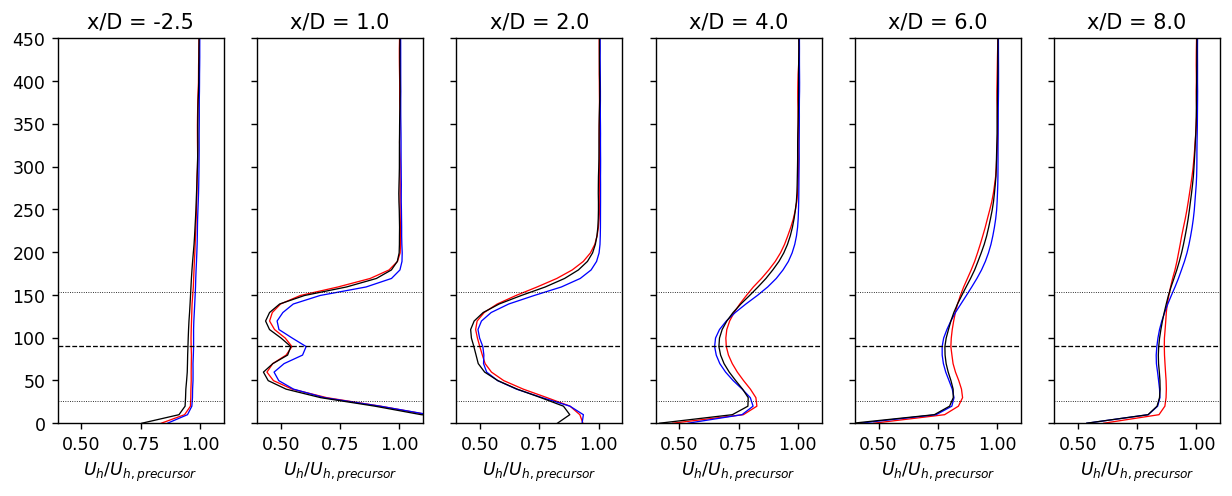

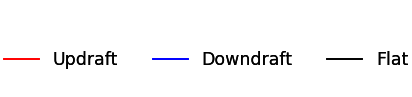

In [32]:
# U plots
yvec=zp[:,0]
xvec=xp[0,:]
ivec = [70, 115, 127, 153, 178, 204]

fig, axs = plt.subplots(1, len(ivec), figsize=(12, 4), dpi=125, sharey=True)
plotvar = 'velocityy_avg'
for ix, ax in enumerate(axs):
    i = ivec[ix]
    # Create Uhoriz
    Uhoriz_up  = np.sqrt(avgup_wturb['velocityx_avg'][0,:,i]**2 + avgup_wturb['velocityy_avg'][0,:,i]**2)
    Uhoriz_down = np.sqrt(avgdown_wturb['velocityx_avg'][0,:,i]**2 + avgdown_wturb['velocityy_avg'][0,:,i]**2)
    Uhoriz_flat = np.sqrt(avgflat_wturb['velocityx_avg'][0,:,i]**2 + avgflat_wturb['velocityy_avg'][0,:,i]**2)

    Uhoriz_up_pre  = np.sqrt(avgup_noturb['velocityx_avg'][0,:,i]**2 + avgup_noturb['velocityy_avg'][0,:,i]**2)
    Uhoriz_down_pre = np.sqrt(avgdown_noturb['velocityx_avg'][0,:,i]**2 + avgdown_noturb['velocityy_avg'][0,:,i]**2)
    Uhoriz_flat_pre = np.sqrt(avgflat_noturb['velocityx_avg'][0,:,i]**2 + avgflat_noturb['velocityy_avg'][0,:,i]**2)
    
    ax.plot(Uhoriz_up/Uhoriz_up_pre, yvec, 'r', lw=0.75, label='Updraft')
    ax.plot(Uhoriz_down/Uhoriz_down_pre, yvec, 'b', lw=0.75, label='Downdraft')
    ax.plot(Uhoriz_flat/Uhoriz_flat_pre, yvec, 'k', lw=0.75, label='Flat')
    ax.set_title('x/D = %0.1f'%(xvec[i]/rotorD))

    #ax.set_xlabel('$U_h$ [$m/s$]')
    ax.set_xlabel('$U_h/U_{h,precursor}$')
    ax.axhline(zhh, ls='--', color='k', lw=0.75)
    ax.axhline(zhh+0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.axhline(zhh-0.5*rotorD, ls=':', color='k', lw=0.5)
    #ax.set_xlim([0, 11])
    ax.set_xlim([0.4, 1.1])
    ax.set_ylim([0, 450])
    #ax.grid()

makelegend(showprecursor=False)

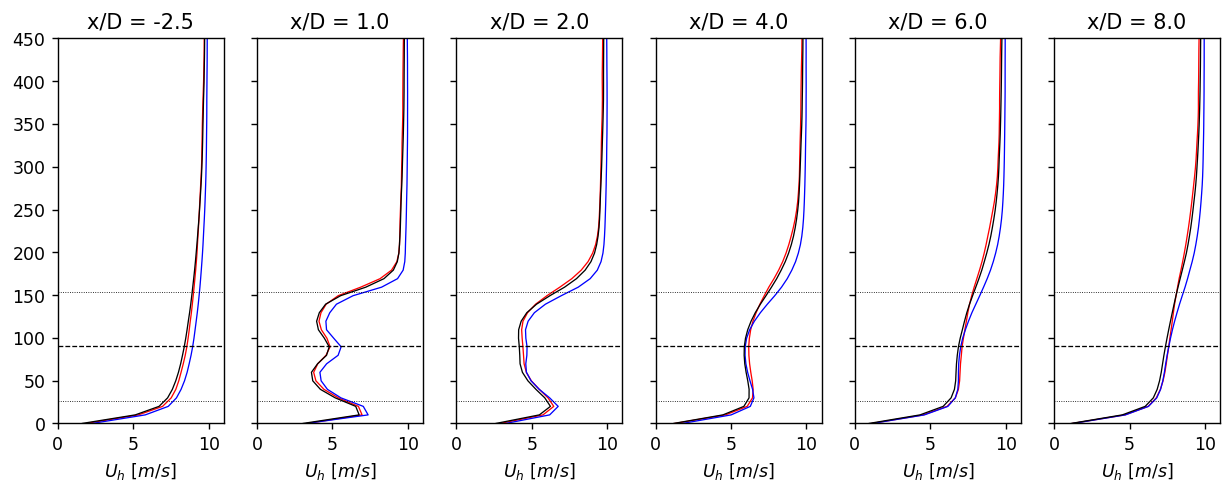

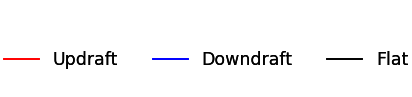

In [33]:
# U plots
yvec=zp[:,0]
xvec=xp[0,:]
ivec = [70, 115, 127, 153, 178, 204]

fig, axs = plt.subplots(1, len(ivec), figsize=(12, 4), dpi=125, sharey=True)
plotvar = 'velocityy_avg'
for ix, ax in enumerate(axs):
    i = ivec[ix]
    # Create Uhoriz
    Uhoriz_up  = np.sqrt(avgup_wturb['velocityx_avg'][0,:,i]**2 + avgup_wturb['velocityy_avg'][0,:,i]**2)
    Uhoriz_down = np.sqrt(avgdown_wturb['velocityx_avg'][0,:,i]**2 + avgdown_wturb['velocityy_avg'][0,:,i]**2)
    Uhoriz_flat = np.sqrt(avgflat_wturb['velocityx_avg'][0,:,i]**2 + avgflat_wturb['velocityy_avg'][0,:,i]**2)

    Uhoriz_up_pre  = np.sqrt(avgup_noturb['velocityx_avg'][0,:,i]**2 + avgup_noturb['velocityy_avg'][0,:,i]**2)
    Uhoriz_down_pre = np.sqrt(avgdown_noturb['velocityx_avg'][0,:,i]**2 + avgdown_noturb['velocityy_avg'][0,:,i]**2)
    
    ax.plot(Uhoriz_up, yvec, 'r', lw=0.75, label='Updraft')
    ax.plot(Uhoriz_down, yvec, 'b', lw=0.75, label='Downdraft')
    ax.plot(Uhoriz_flat, yvec, 'k', lw=0.75, label='Flat')
    ax.set_title('x/D = %0.1f'%(xvec[i]/rotorD))

    ax.set_xlabel('$U_h$ [$m/s$]')
    #ax.set_xlabel('$U_h/U_{h,precursor}$')
    ax.axhline(zhh, ls='--', color='k', lw=0.75)
    ax.axhline(zhh+0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.axhline(zhh-0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.set_xlim([0, 11])
    #ax.set_xlim([0.4, 1.1])
    ax.set_ylim([0, 450])
    
makelegend(showprecursor=False)

## Look at Reynolds stresses

In [24]:
# Load the SW  pickle files
picklefile     = 'AllKP_SW_ReStress_noturb.pkl'
pfile          = open(picklefile, 'rb')
ReStress_noturb   = pickle.load(pfile)
pfile.close()

picklefile     = 'AllKP_SW_ReStress_wturb.pkl'
pfile          = open(picklefile, 'rb')
ReStress_wturb    = pickle.load(pfile)
pfile.close()

In [25]:
avgReStress_up_noturb   = avgDSfield(ReStress_noturb, updraftturbs[:])
avgReStress_up_wturb    = avgDSfield(ReStress_wturb,  updraftturbs[:])
avgReStress_down_noturb = avgDSfield(ReStress_noturb, downdraftturbs[:])
avgReStress_down_wturb  = avgDSfield(ReStress_wturb,  downdraftturbs[:])

avgReStress_flat_wturb  = avgDSfield(ReStress_wturb,  nodraftturbs[:])

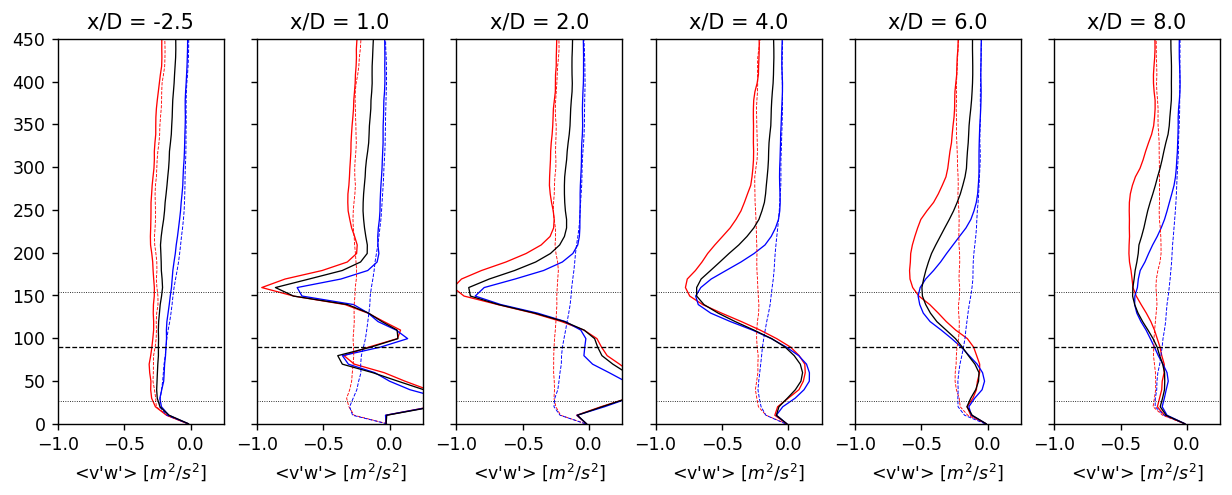

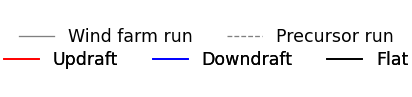

In [26]:
# W plots
yvec=zp[:,0]
xvec=xp[0,:]
ivec = [70, 115, 127, 153, 178, 204]

fig, axs = plt.subplots(1, len(ivec), figsize=(12, 4), dpi=125, sharey=True)
plotvar = 'vw_avg'
for ix, ax in enumerate(axs):
    i = ivec[ix]
    ax.plot(avgReStress_up_wturb[plotvar][0,:,i], yvec, 'r', lw=0.75, label='Updraft')
    ax.plot(avgReStress_down_wturb[plotvar][0,:,i], yvec, 'b', lw=0.75, label='Downdraft')

    ax.plot(avgReStress_up_noturb[plotvar][0,:,i], yvec, 'r--', lw=0.5, )
    ax.plot(avgReStress_down_noturb[plotvar][0,:,i], yvec, 'b--', lw=0.55,)

    ax.plot(avgReStress_flat_wturb[plotvar][0,:,i], yvec,  'k', lw=0.75, label='Flat')
    
    ax.set_title('x/D = %0.1f'%(xvec[i]/rotorD))

    ax.set_xlabel(r"<v'w'> [$m^2/s^2$]")
    ax.axhline(zhh, ls='--', color='k', lw=0.75)
    ax.axhline(zhh+0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.axhline(zhh-0.5*rotorD, ls=':', color='k', lw=0.5)
    ax.set_xlim([-1, 0.25])
    ax.set_ylim([0, 450])
    #ax.grid(':', lw=0.25)

#axs[-1].legend(loc='upper left')
makelegend()

In [27]:
for k, g in avgReStress_up_wturb.items(): print(k)

x
y
z
velocityx_avg
velocityy_avg
velocityz_avg
uu_avg
uv_avg
uw_avg
vv_avg
vw_avg
ww_avg
